In [1]:
import numpy as np
import cv2
import os
import pykitti
from point_viz.converter import PointvizConverter

In [2]:
basedir = '/home/hpaat/courses/comp6411b/'
date = '2011_09_28'
drive = '0002'

output_path = '/home/hpaat/courses/comp6411b/artifacts'

# The 'frames' argument is optional - default: None, which loads the whole dataset.
# Calibration, timestamps, and IMU data are read automatically. 
# Camera and velodyne data are available via properties that create generators
# when accessed, or through getter methods that provide random access.
frame_sequence = range(0, 100,10)
data = pykitti.raw(basedir, date, drive, frames=frame_sequence)

# dataset.calib:         Calibration data are accessible as a named tuple
# dataset.timestamps:    Timestamps are parsed into a list of datetime objects
# dataset.oxts:          List of OXTS packets and 6-dof poses as named tuples
# dataset.camN:          Returns a generator that loads individual images from camera N
# dataset.get_camN(idx): Returns the image from camera N at idx  
# dataset.gray:          Returns a generator that loads monochrome stereo pairs (cam0, cam1)
# dataset.get_gray(idx): Returns the monochrome stereo pair at idx  
# dataset.rgb:           Returns a generator that loads RGB stereo pairs (cam2, cam3)
# dataset.get_rgb(idx):  Returns the RGB stereo pair at idx  
# dataset.velo:          Returns a generator that loads velodyne scans as [x,y,z,reflectance]
# dataset.get_velo(idx): Returns the velodyne scan at idx  

point_velo = np.array([0,0,0,1])
point_cam0 = data.calib.T_cam0_velo.dot(point_velo)

for cam0_image in data.cam0:
    pass

cam2_image, cam3_image = data.get_rgb(0)
filename = "cam2.png"
open_cv_image = np.array(cam2_image) 
open_cv_image = open_cv_image[:, :, ::-1].copy()
cv2.imwrite(os.path.join(output_path, filename), open_cv_image)

Converter = PointvizConverter(home='/home/hpaat/courses/comp6411b/artifacts/agg_pointcoud')

point_imu = np.array([0,0,0,1])
point_w = [o.T_w_imu.dot(point_imu) for o in data.oxts]
point_w = np.array(point_w)

print(point_w[:,[2,0,1]])
# point_w = np.concatenate(point_w,axis=0)
# print(point_w.shape)
# print(len(point_w))
# for i in range(len(point_w)):
#     print(point_w[i])

Converter.compile(task_name="point_w",
                coors=point_w[:,[2,0,1]],
                intensity=np.arange(point_w.shape[0]).astype(np.float32))

# pc_generator = data.velo
# for i in range(len(frame_sequence)):
#     pc = next(pc_generator)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.19888306e-02 -7.26901985e-01 -1.18415840e+01]
 [ 9.30480957e-02 -1.51191130e+00 -2.33246325e+01]
 [ 1.44561768e-01 -2.33443567e+00 -3.46968463e+01]
 [ 1.26716614e-01 -3.17527379e+00 -4.55119733e+01]
 [ 1.24885559e-01 -3.90390722e+00 -5.48694982e+01]
 [ 1.37153625e-01 -4.42580253e+00 -6.21229666e+01]
 [ 1.46293640e-01 -4.75110454e+00 -6.70784366e+01]
 [ 1.52030945e-01 -4.92113387e+00 -6.97953779e+01]
 [ 2.72415161e-01 -4.95613526e+00 -7.05848680e+01]]


In [63]:
# Converter.compile(task_name="Pc_seq_valid_" + str(i),
#                 coors=pc[:,[1,2,0]],
#                 intensity=pc[:,3])
from numpy.linalg import inv

# Load R_rect,
R_rect_02 = np.array([[9.998691e-01, 1.512763e-02, -5.741851e-03,0],
           [-1.512861e-02, 9.998855e-01, -1.287536e-04,0],
           [5.739247e-03, 2.156030e-04, 9.999835e-01,0],
          [0,0,0,1]])

## compute T_imu_cam2
T_cam2_imu = data.calib.T_cam2_imu
R_imu_cam2 = T_cam2_imu[:3,:3]
d_imu_cam2 = T_cam2_imu[:3,3]
inv_R_imu_cam2 = np.linalg.inv(R_imu_cam2) 
d_cam2_imu = -inv_R_imu_cam2.dot(d_imu_cam2)

T_imu_cam2 = np.eye(4, dtype=np.float32)
T_imu_cam2[:3,:3] = inv_R_imu_cam2
T_imu_cam2[:3,3] = d_cam2_imu

# compute T_imu_velo
T_velo_imu = data.calib.T_velo_imu

R_imu_velo = T_velo_imu[:3,:3]
d_imu_velo = T_velo_imu[:3,3]
inv_R_imu_velo = np.linalg.inv(R_imu_velo) 
d_velo_imu = -inv_R_imu_velo.dot(d_imu_velo) #.T)

T_imu_velo = np.eye(4, dtype=np.float32)
T_imu_velo[:3,:3] = inv_R_imu_velo
T_imu_velo[:3,3] = d_velo_imu

# Initiliaze empty lists
T_w_cam2_list = []
T_w_velo_list = []

point_w_world = []
velo_world = []

point_cam2 = np.array([0,0,0,1])
pc_gen = data.velo

origin = None

for idx, o in enumerate(data.oxts):
    T_w_cam2 = o.T_w_imu.dot(T_imu_cam2) #.dot(inv(R_rect_02))
    T_w_cam2_list.append(T_w_cam2) 
  
    T_w_velo = o.T_w_imu.dot(T_imu_velo)
    #print(T_w_velo)
    T_w_velo_list.append(T_w_velo)
    
    point_w = T_w_cam2.dot(point_cam2)
    if origin is None:
        origin = point_w

    # diff_z = point_w[2] - origin[2]
    # point_w[2] = origin[2]
    point_w_world.append(point_w)
    
    
    # Projecting velo points to world
    pc_t = next(pc_gen)
    homogenuous_velo_points = np.ones_like(pc_t)
    homogenuous_velo_points[:,:3] = pc_t[:,:3]
    print(homogenuous_velo_points)
    #velo_w = T_w_velo.dot(homogenuous_velo_points.T).T
    velo_w = np.dot(homogenuous_velo_points, np.transpose(T_w_velo[:3,:]))
    # velo_w[:,2] -= diff_z
    
    n = velo_w.shape[0]
    velo_w = np.hstack((velo_w, np.full((n,1), idx*20)))
    print(velo_w)
    #print(velo_w.shape)
    velo_world.append(velo_w)
    
    #import sys; sys.exit()
    


point_w_world = np.array(point_w_world)
velo_world_np = np.concatenate(velo_world, axis=0)
print(velo_world_np.shape)
#print(point_w_world.shape)

# subsample_size = 1000000
# subsample_p\t_ind = np.random.choice(velo_world_np.shape[0], size=subsample_size, replace=False)
# velo_world_np = velo_world_np[subsample_pt_ind,:]
all_points = np.concatenate([point_w_world, velo_world_np], axis=0)
print(all_points)

Converter.compile(task_name="all_points",
                coors=all_points[:,[1,2,0]],
                intensity=np.arange(all_points.shape[0]).astype(np.float32))

[[77.036 18.672  2.89   1.   ]
 [76.578 18.816  2.876  1.   ]
 [76.532 18.932  2.875  1.   ]
 ...
 [ 3.713 -1.404 -1.735  1.   ]
 [ 3.712 -1.397 -1.733  1.   ]
 [ 3.714 -1.385 -1.732  1.   ]]
[[ 12.77463243 -78.97099222   3.25759313   0.        ]
 [ 12.95037621 -78.52399645   3.25539407   0.        ]
 [ 13.06923366 -78.4861698    3.25931246   0.        ]
 ...
 [ -1.99559121  -4.37956676  -1.06205156   0.        ]
 [ -1.98861903  -4.3790796   -1.05978157   0.        ]
 [ -1.97683225  -4.3819217   -1.05836946   0.        ]]
[[68.995  6.015  2.551  1.   ]
 [68.813  6.217  2.545  1.   ]
 [68.755  6.429  2.544  1.   ]
 ...
 [ 3.74  -1.415 -1.748  1.   ]
 [ 3.753 -1.406 -1.753  1.   ]
 [ 3.769 -1.399 -1.758  1.   ]]
[[-2.50680550e-01 -8.19250094e+01  2.13707956e+00  2.00000000e+01]
 [-3.58689256e-02 -8.17582753e+01  2.14149346e+00  2.00000000e+01]
 [ 1.79704379e-01 -8.17160049e+01  2.14863821e+00  2.00000000e+01]
 ...
 [-2.75490725e+00 -1.62321361e+01 -1.03738128e+00  2.00000000e+01]
 [-2.74

range(0, 1230425, 5)
[[ -1.12741555  -0.38280031   0.71189539   1.        ]
 [-56.00110803  -4.28007683   0.83365397   1.        ]
 [-78.97099222  12.77463243   3.25759313   0.        ]
 ...
 [-74.88051928  -7.05499705  -0.77959604 180.        ]
 [-74.90771156  -7.00663183  -0.7807746  180.        ]
 [-74.93729324  -6.95241195  -0.78183784 180.        ]]


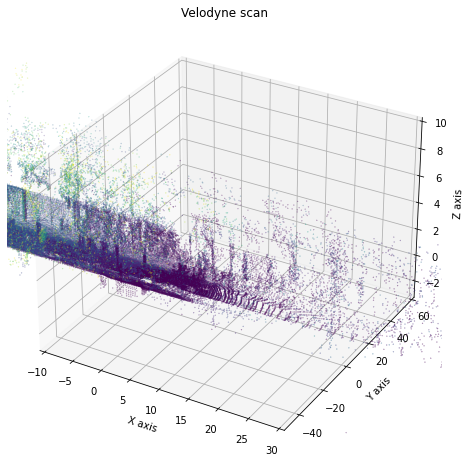

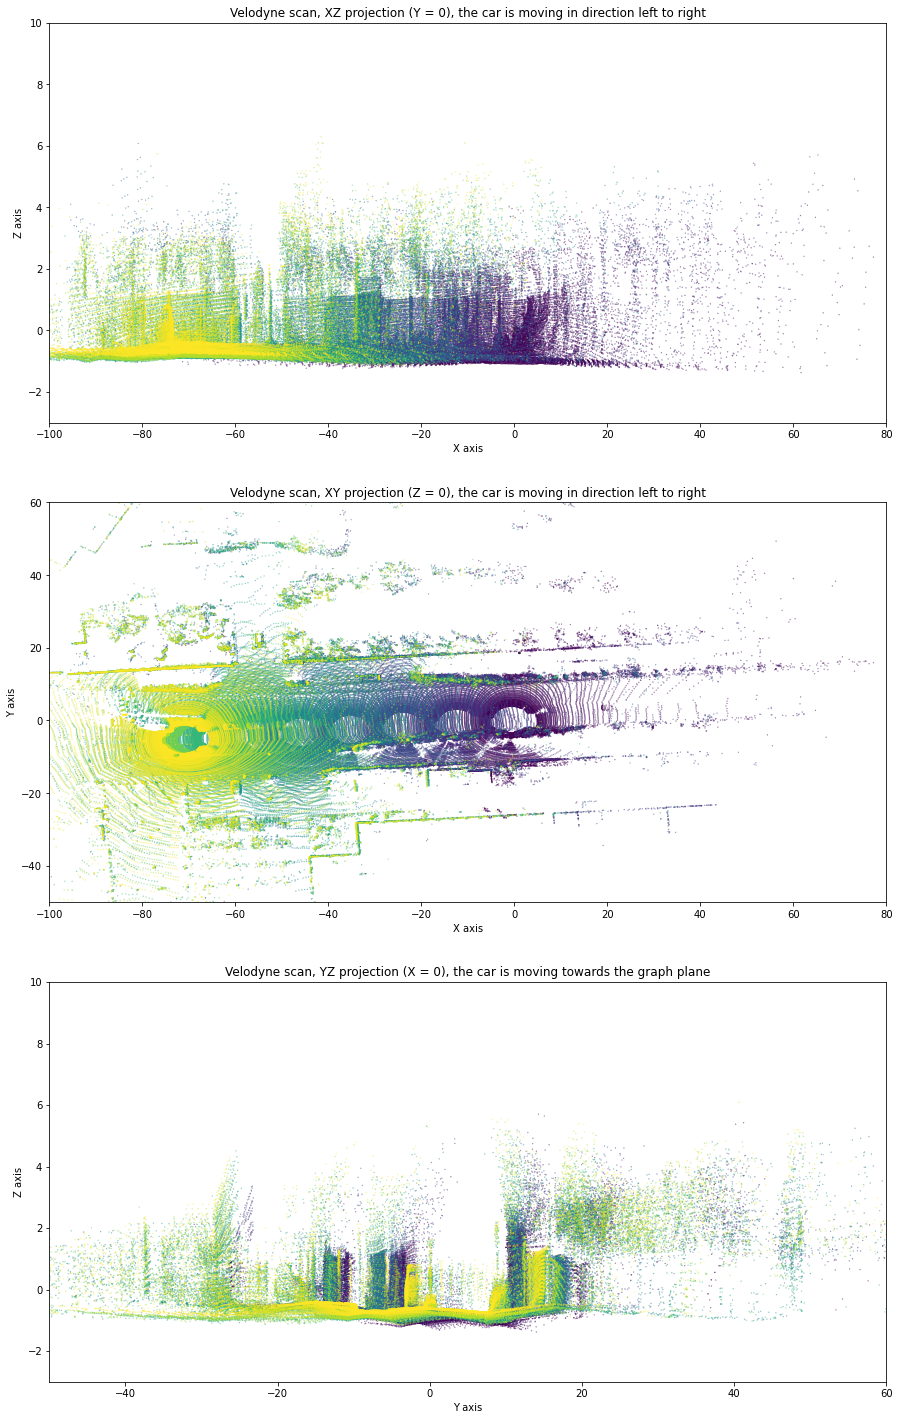

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dataset_velo_frame = all_points[:,[1,0,2,3]]
points = 0.20

points_step = int(1. / points)
point_size = 0.01 * (1. / points)
velo_range = range(0, dataset_velo_frame.shape[0], points_step)
print(velo_range)
velo_frame = dataset_velo_frame[velo_range, :]      
print(velo_frame)

axes_limits = [
    [-100, 80], # X axis range
    [-50, 60], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']
def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
    """
    Convenient method for drawing various point cloud projections as a part of frame statistics.
    """
    ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3]) # , cmap='gray'
    ax.set_title(title)
    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])
    # User specified limits
    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

    #for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        #draw_box(ax, t_rects, axes=axes, color=colors[t_type])

# Draw point cloud data as 3D plot
f2 = plt.figure(figsize=(15, 8))
ax2 = f2.add_subplot(111, projection='3d')                    
draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
plt.show()
    
# Draw point cloud data as plane projections
f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
draw_point_cloud(
    ax3[0], 
    'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
    axes=[0, 2] # X and Z axes
)
draw_point_cloud(
    ax3[1], 
    'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
    axes=[0, 1] # X and Y axes
)
draw_point_cloud(
    ax3[2], 
    'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
    axes=[1, 2] # Y and Z axes
)
plt.show()